In [3]:
import os
import json
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from skimage.draw import polygon
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

num_classes = 2
image_size = 256
batch_size = 4


Using device: cuda


In [4]:
class CocoMaskedDataset(Dataset):
    def __init__(self, images_path, annotations_path, transform=None):
        self.images_path = images_path
        self.transform = transform
        with open(annotations_path, "r") as f:
            coco = json.load(f)
        self.images = {img["id"]: img["file_name"] for img in coco["images"]}
        self.annotations = {}
        for ann in coco["annotations"]:
            img_id = ann["image_id"]
            if img_id not in self.annotations:
                self.annotations[img_id] = []
            self.annotations[img_id].append(ann)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_id = list(self.images.keys())[idx]
        img_path = os.path.join(self.images_path, self.images[img_id])
        img = np.array(Image.open(img_path).convert("RGB"))
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        anns = self.annotations.get(img_id, [])
        for ann in anns:
            for seg in ann["segmentation"]:
                if isinstance(seg, list) and len(seg) % 2 == 0:
                    poly = np.array(seg).reshape(-1, 2)
                    rr, cc = polygon(poly[:, 1], poly[:, 0], shape=img.shape[:2])
                    mask[rr, cc] = 1
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]
        return img, mask.long()


In [5]:
val_transform = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

images_path = r"D:\val2017\val2017"
annotations_path = r"D:\annotations_trainval2017\annotations\instances_val2017.json"

dataset = CocoMaskedDataset(images_path, annotations_path, transform=val_transform)
val_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)


In [6]:
weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = deeplabv3_resnet50(weights=weights, aux_loss=True)

old_head = model.classifier
new_head = nn.Sequential(
    old_head[0],
    old_head[1],
    old_head[2],
    old_head[3],
    nn.Conv2d(256, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(128, num_classes, kernel_size=1)
)
model.classifier = new_head
model.to(device)

model.load_state_dict(torch.load("deeplabv3_custom_final.pth", map_location=device))
print("✅ Loaded model weights")


C:\Users\puliu\AppData\Local\Temp\ipykernel_25052\525287692.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("deeplabv3_custom_final.pth

✅ Loaded model weights


In [7]:
def iou_score(preds, masks, num_classes=num_classes):
    preds = torch.argmax(preds, dim=1)
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (masks == cls)
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()
        ious.append((intersection / union).item() if union != 0 else float('nan'))
    return np.nanmean(ious)

def dice_score(preds, masks, num_classes=num_classes):
    preds = torch.argmax(preds, dim=1)
    dices = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (masks == cls)
        intersection = (pred_inds & target_inds).sum().float() * 2
        denominator = pred_inds.sum().float() + target_inds.sum().float()
        dices.append((intersection / denominator).item() if denominator != 0 else float('nan'))
    return np.nanmean(dices)

def pixel_accuracy(preds, masks):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == masks).sum().float()
    total = torch.numel(masks)
    return (correct / total).item()


In [8]:
def evaluate_model(model, dataloader):
    model.eval()
    metrics = {"IoU": [], "Dice": [], "PixelAcc": []}
    with torch.no_grad():
        for imgs, masks in tqdm(dataloader, desc="Evaluating", unit="batch"):
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)["out"]
            metrics["IoU"].append(iou_score(outputs, masks))
            metrics["Dice"].append(dice_score(outputs, masks))
            metrics["PixelAcc"].append(pixel_accuracy(outputs, masks))
    print(f"\n📊 Evaluation Results:")
    print(f"Mean IoU: {np.mean(metrics['IoU']):.4f}")
    print(f"Mean Dice: {np.mean(metrics['Dice']):.4f}")
    print(f"Pixel Accuracy: {np.mean(metrics['PixelAcc']):.4f}")

evaluate_model(model, val_loader)


Evaluating: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [11:01<00:00,  1.89batch/s]


📊 Evaluation Results:
Mean IoU: 0.8291
Mean Dice: 0.9024
Pixel Accuracy: 0.9222


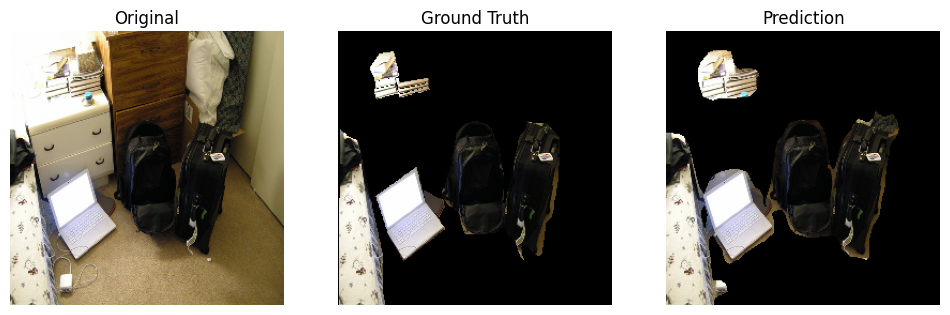

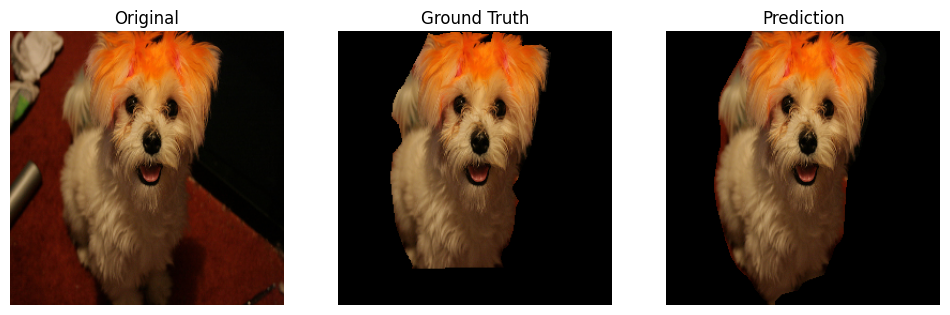

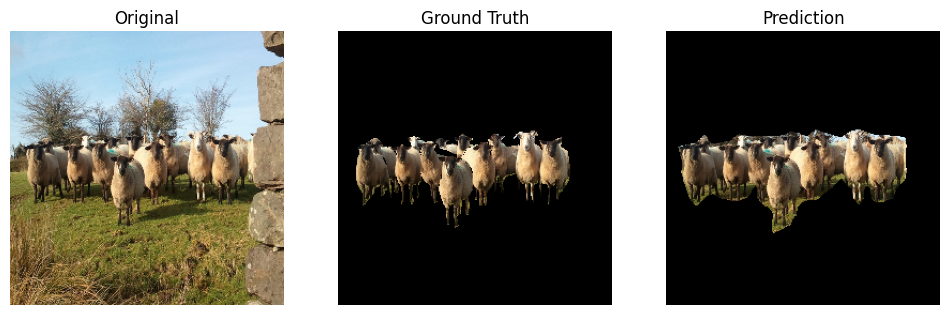

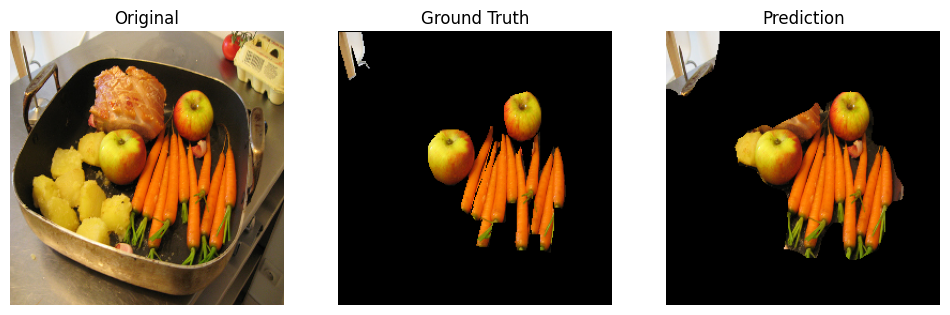

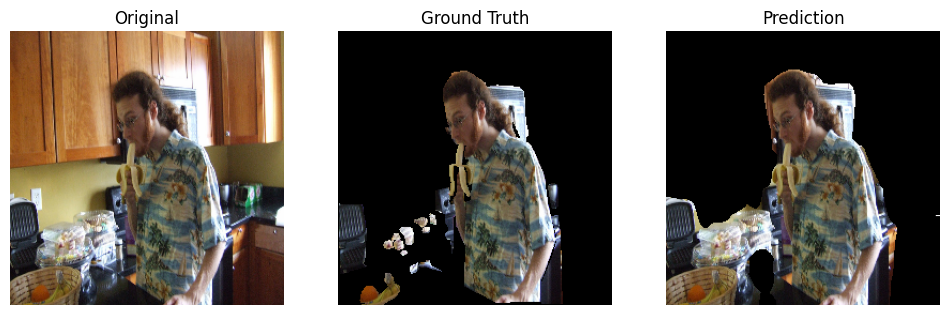

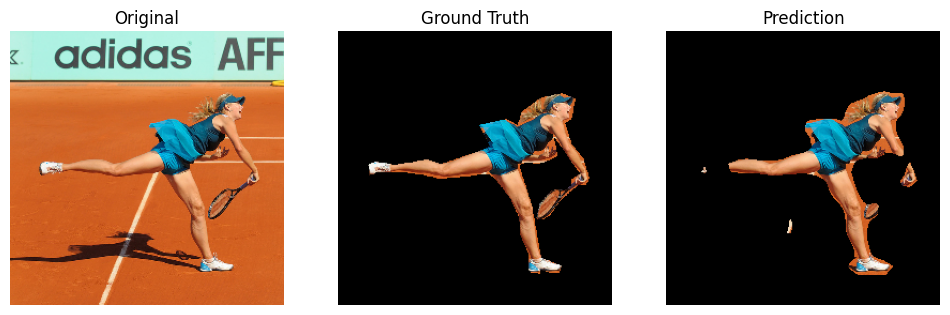

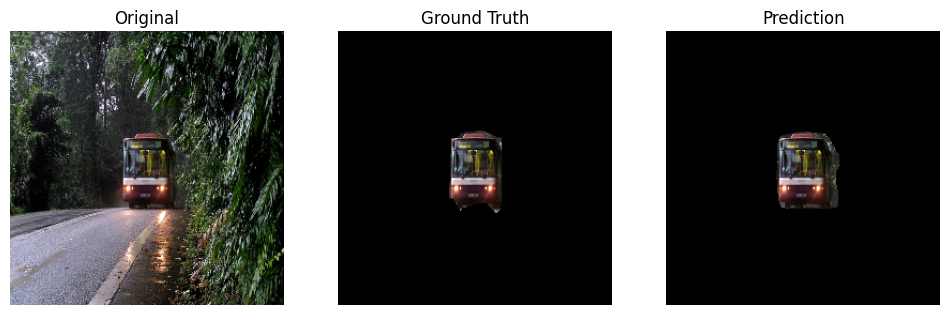

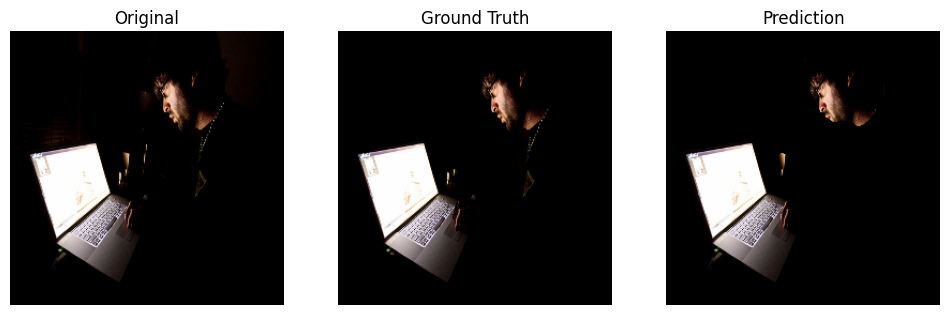

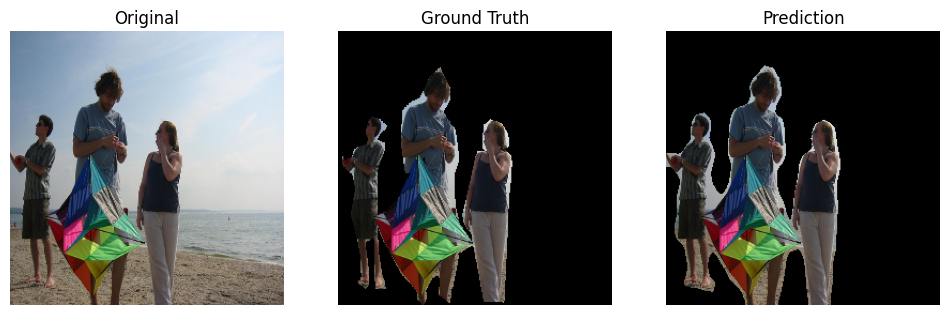

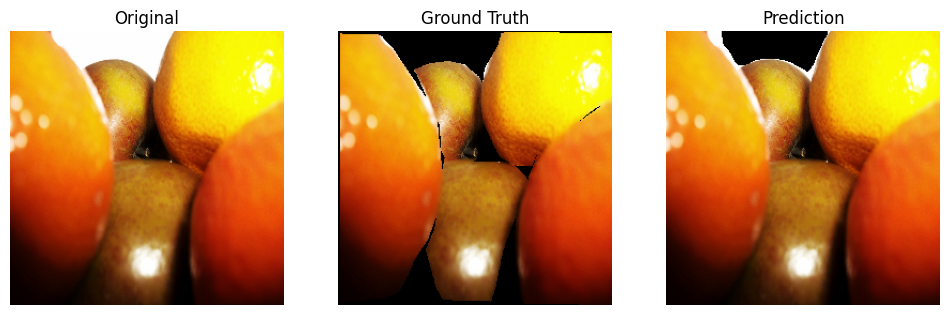

In [9]:
def visualize_samples(model, dataloader, num_samples=5):
    model.eval()
    shown = 0
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)["out"]
            preds = torch.argmax(outputs, dim=1).cpu()

            for i in range(imgs.size(0)):
                img = imgs[i].cpu().permute(1, 2, 0).numpy()
                img = np.clip(img * std + mean, 0, 1)

                mask_gt = masks[i].cpu().numpy()
                mask_pred = preds[i].numpy()

                gt_overlay = np.zeros_like(img)
                gt_overlay[mask_gt == 1] = img[mask_gt == 1]

                pred_overlay = np.zeros_like(img)
                pred_overlay[mask_pred == 1] = img[mask_pred == 1]

                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(img)
                axs[0].set_title("Original")
                axs[0].axis("off")

                axs[1].imshow(gt_overlay)
                axs[1].set_title("Ground Truth")
                axs[1].axis("off")

                axs[2].imshow(pred_overlay)
                axs[2].set_title("Prediction")
                axs[2].axis("off")

                plt.show()

                shown += 1
                if shown >= num_samples:
                    return

visualize_samples(model, val_loader, num_samples=10)
